<a href="https://colab.research.google.com/github/susie682/Infosys722--Assignment-4-BDAS/blob/main/6_1_AlgoExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 6.1 — Exploratory Analysis of Data-Mining Algorithms (Reproducible, Colab-Ready)

This notebook is designed for **Google Colab** and will:
- Mount Google Drive
- Robustly resolve the input CSV path under your project folder
- Run **seed-fixed**, **time-aware** experiments for Section 6.1
- Generate and save the following figures to `/content/drive/MyDrive/Infosys 722/figs/`:
  - **Figure 53**: Precision–Recall curves (Logistic / RandomForest / GBClassifier)
  - **Figure 54**: Recall@K (K = 10% per month, macro-averaged across test months)
  - **Figure 55**: RandomForest feature importance (top 12)
  - **Figure 56**: GradientBoosting feature importance (top 12)
  - **Figure 57**: MAE — Regression models vs naïve baselines


In [1]:

# ==== 0. Mount Google Drive and set paths (Colab) ====
import os

from google.colab import drive  # Colab environment only
ROOT = "/content/drive/MyDrive/Infosys 722"
TAB_DIR = os.path.join(ROOT, "tables")
FIG_DIR = os.path.join(ROOT, "figs")

if not os.path.exists(ROOT):
    drive.mount('/content/drive')

os.makedirs(FIG_DIR, exist_ok=True)

print("ROOT    :", ROOT)
print("TAB_DIR :", TAB_DIR)
print("FIG_DIR :", FIG_DIR)


Mounted at /content/drive
ROOT    : /content/drive/MyDrive/Infosys 722
TAB_DIR : /content/drive/MyDrive/Infosys 722/tables
FIG_DIR : /content/drive/MyDrive/Infosys 722/figs


In [2]:

# ==== 1. Resolve CSV path robustly ====
import os, glob

# Preferred filenames (produced by Section 4.2)
preferred_names = [
    "CrimeData2017_reduced_projected.csv",  # main expected file
    "CrimeData2017_reduced.csv",            # fallback if projected is missing
    "features_district_month.csv",          # another common name used earlier
]

CSV_PATH = None

# 1) Try expected location under tables/
for name in preferred_names:
    candidate = os.path.join(TAB_DIR, name)
    if os.path.isfile(candidate):
        CSV_PATH = candidate
        break

# 2) If not found, recursively search under project root for likely names
if CSV_PATH is None:
    patterns = [
        "**/*reduced*projected*.csv",
        "**/CrimeData2017*.csv",
        "**/*features*district*month*.csv",
        "**/*projected*.csv",
    ]
    matches = []
    for pat in patterns:
        matches.extend(glob.glob(os.path.join(ROOT, pat), recursive=True))
    # Prefer matches under the tables/ folder; otherwise shortest path
    matches_sorted = sorted(matches, key=lambda p: (0 if p.startswith(TAB_DIR) else 1, len(p)))
    if matches_sorted:
        CSV_PATH = matches_sorted[0]
        print("Auto-detected CSV:", CSV_PATH)

# 3) If still not found, dump a directory listing for debugging and raise a clear error
if CSV_PATH is None:
    print("\n[DEBUG] Could not find the expected CSV automatically.")
    print("[DEBUG] Listing files under:", TAB_DIR)
    if os.path.isdir(TAB_DIR):
        for f in sorted(os.listdir(TAB_DIR)):
            print(" -", f)
    raise FileNotFoundError(
        "CSV not found. Please place 'CrimeData2017_reduced_projected.csv' in "
        f"{TAB_DIR} or update 'CSV_PATH' manually."
    )

print("CSV_PATH resolved to:", CSV_PATH)


CSV_PATH resolved to: /content/drive/MyDrive/Infosys 722/tables/CrimeData2017_reduced_projected.csv


In [3]:

# ==== 2. Imports & global config ====
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve, average_precision_score, mean_absolute_error
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    RandomForestRegressor, GradientBoostingRegressor
)

warnings.filterwarnings("ignore")

SEED = 42
np.random.seed(SEED)

print("SEED fixed to:", SEED)


SEED fixed to: 42


In [4]:

# ==== 3. Load data (uses CSV_PATH resolved above) ====
df = pd.read_csv(CSV_PATH)
print("Loaded shape:", df.shape)
print("Columns (head):", list(df.columns)[:25])

# Basic sanity checks
must_have = ["District", "Month", "Total"]
missing = [c for c in must_have if c not in df.columns]
if missing:
    raise ValueError(f"Missing required column(s): {missing}")

# Month coercion
if not np.issubdtype(df["Month"].dtype, np.number):
    df["Month"] = pd.to_numeric(df["Month"], errors="coerce")
if df["Month"].isna().any():
    # As a last resort only; better to fix at source
    df["Month"] = (pd.Series(range(1, len(df)+1)) % 12) + 1

# District normalization
df["District"] = df["District"].astype(str).str.strip()
df = df.dropna(subset=["District", "Month", "Total"]).copy()

# Next-month target: prefer explicit y_count_next; else invert log1p; else shift Total
if "y_count_next" in df.columns:
    y_next = df["y_count_next"]
elif "y_count_next_log1p" in df.columns:
    y_next = np.expm1(df["y_count_next_log1p"].clip(lower=0))
else:
    y_next = df.sort_values(["District","Month"]).groupby("District")["Total"].shift(-1)
df["y_next"] = y_next

uniq_months = sorted(pd.unique(df["Month"].astype(int)))
print("Unique months:", uniq_months)


Loaded shape: (267, 15)
Columns (head): ['District', 'Month', 'Total', 'District_Month_ArrestRate', 'District_Month_DomesticRate', 'NightShare_DistMonth', 'OutdoorShare_DistMonth', 'Roll3Mean_DistMonth', 'y_count_next', 'District_Month_ArrestRate_logit', 'District_Month_DomesticRate_logit', 'NightShare_DistMonth_logit', 'OutdoorShare_DistMonth_logit', 'Roll3Mean_DistMonth_log1p', 'y_count_next_log1p']
Unique months: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12)]


In [5]:

# ==== 4. Feature assembly & hotspot labels ====
# Prefer projected versions where available
cand_cols = []
for c in [
    "Roll3Mean_DistMonth_log1p",
    "District_Month_ArrestRate_logit",
    "OutdoorShare_DistMonth_logit",
    "NightShare_DistMonth_logit",
    "District_Month_DomesticRate_logit",
    "Total_log1p",
]:
    if c in df.columns:
        cand_cols.append(c)

# Fallback to raw names if projected not present
fallback_map = {
    "Roll3Mean_DistMonth_log1p": "Roll3Mean_DistMonth",
    "District_Month_ArrestRate_logit": "District_Month_ArrestRate",
    "OutdoorShare_DistMonth_logit": "OutdoorShare_DistMonth",
    "NightShare_DistMonth_logit": "NightShare_DistMonth",
    "District_Month_DomesticRate_logit": "District_Month_DomesticRate",
    "Total_log1p": "Total"
}
for k, v in fallback_map.items():
    if k not in cand_cols and v in df.columns:
        cand_cols.append(v)

print("Candidate predictors:", cand_cols)

# Build classification label: top K% by y_next within each month
K_FRAC = 0.10  # 10%
def label_hotspots(g):
    if g["y_next"].notna().sum() == 0:
        return pd.Series(False, index=g.index)
    k = max(1, int(len(g) * K_FRAC))
    top_idx = g["y_next"].rank(method="first", ascending=False) <= k
    return top_idx

df["is_hotspot_next"] = df.groupby("Month", group_keys=False).apply(label_hotspots).astype(int)

# Keep supervised rows only
df_sup = df.dropna(subset=["y_next"]).copy()
print("Supervised sample size:", df_sup.shape)


Candidate predictors: ['Roll3Mean_DistMonth_log1p', 'District_Month_ArrestRate_logit', 'OutdoorShare_DistMonth_logit', 'NightShare_DistMonth_logit', 'District_Month_DomesticRate_logit', 'Total']
Supervised sample size: (243, 17)


In [6]:

# ==== 5. Time-aware split ====
TEST_LAST_N = 3  # last N months as test set
all_months = sorted(pd.unique(df_sup["Month"].astype(int)))
if len(all_months) <= TEST_LAST_N:
    raise ValueError("Not enough unique months for time-aware split.")

train_months = all_months[:-TEST_LAST_N]
test_months  = all_months[-TEST_LAST_N:]
print("Train months:", train_months)
print("Test  months:", test_months)

train_mask = df_sup["Month"].isin(train_months)
test_mask  = df_sup["Month"].isin(test_months)

X_train = df_sup.loc[train_mask, cand_cols].astype(float).fillna(0.0)
X_test  = df_sup.loc[test_mask,  cand_cols].astype(float).fillna(0.0)

y_train_cls = df_sup.loc[train_mask, "is_hotspot_next"].astype(int)
y_test_cls  = df_sup.loc[test_mask,  "is_hotspot_next"].astype(int)

y_train_reg = df_sup.loc[train_mask, "y_next"].astype(float)
y_test_reg  = df_sup.loc[test_mask,  "y_next"].astype(float)

print("X_train / X_test:", X_train.shape, X_test.shape)


Train months: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
Test  months: [np.int64(9), np.int64(10), np.int64(11)]
X_train / X_test: (177, 6) (66, 6)


Saved: /content/drive/MyDrive/Infosys 722/figs/fig53_precision_recall.png


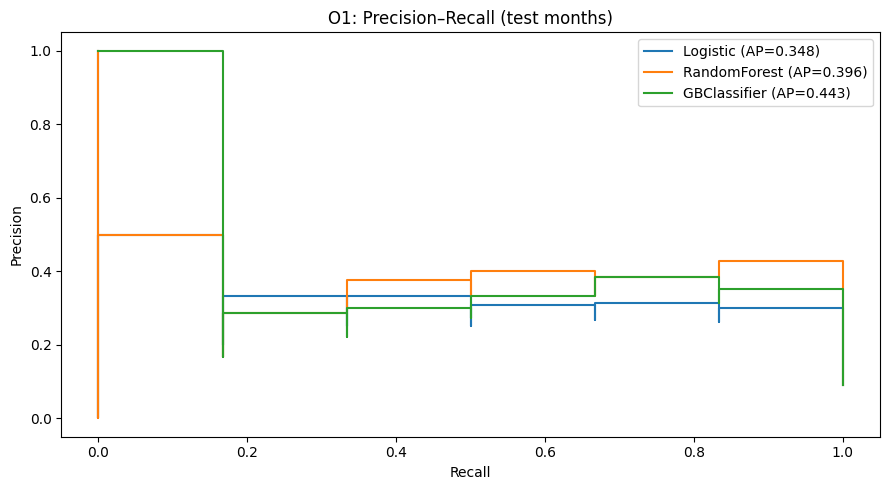

Saved: /content/drive/MyDrive/Infosys 722/figs/fig54_recall_at_k.png


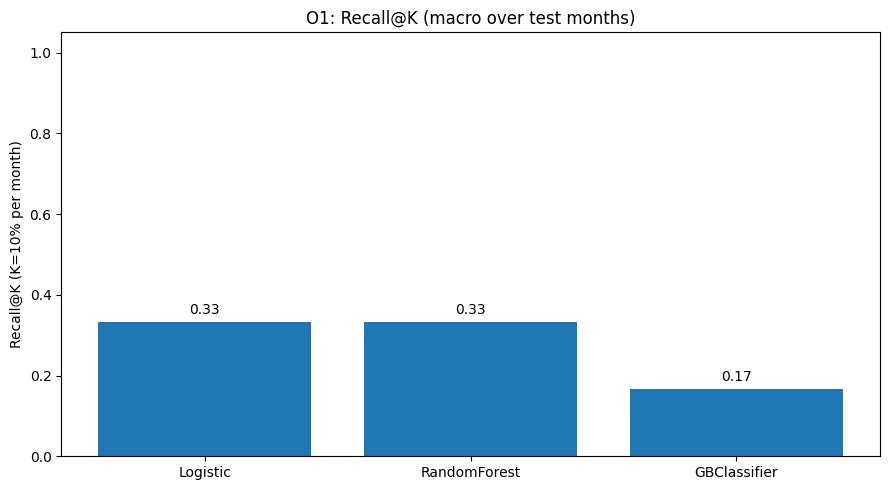

Saved: /content/drive/MyDrive/Infosys 722/figs/fig55_rf_importance.png


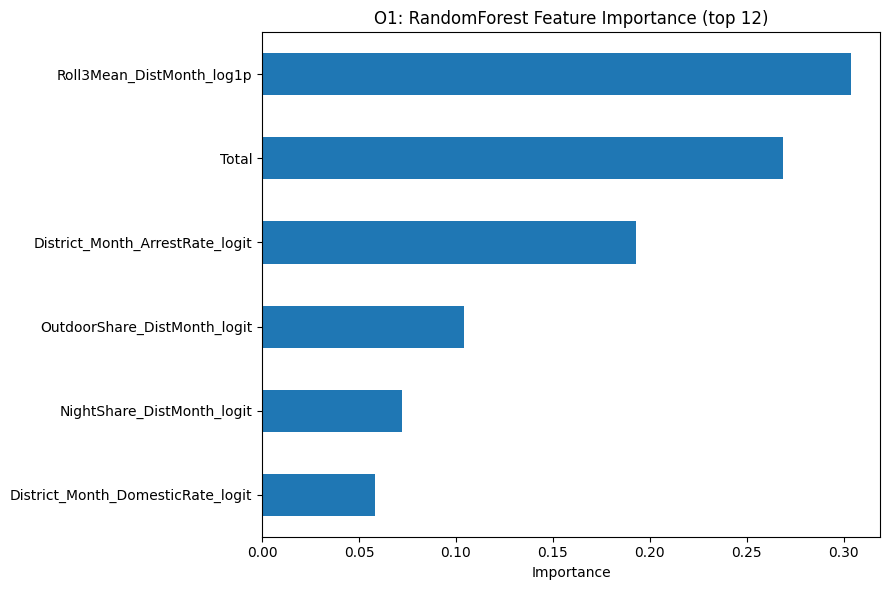

Saved: /content/drive/MyDrive/Infosys 722/figs/fig56_gb_importance.png


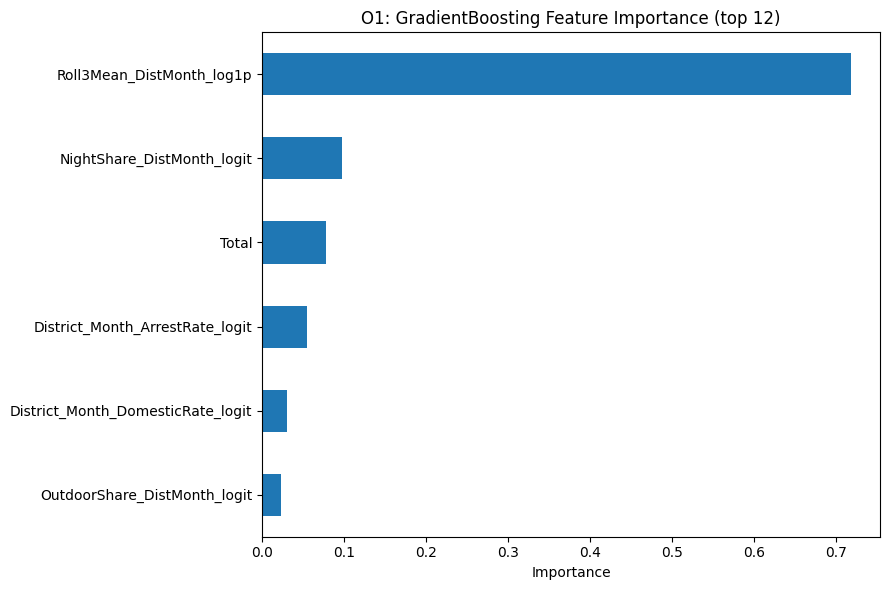

In [7]:

# ==== 6. Objective 1 — Classification (PR, Recall@K, feature importance) ====
from sklearn.metrics import precision_recall_curve, average_precision_score

SEED = 42

clf_log = LogisticRegression(max_iter=200, random_state=SEED)
clf_rf  = RandomForestClassifier(n_estimators=400, random_state=SEED, n_jobs=-1)
clf_gb  = GradientBoostingClassifier(random_state=SEED)

clf_log.fit(X_train, y_train_cls)
clf_rf.fit(X_train, y_train_cls)
clf_gb.fit(X_train, y_train_cls)

probs = {}
for name, clf in [("Logistic", clf_log), ("RandomForest", clf_rf), ("GBClassifier", clf_gb)]:
    p = clf.predict_proba(X_test)[:,1] if hasattr(clf, "predict_proba") else clf.decision_function(X_test)
    probs[name] = p

# Figure 53 — PR curves
plt.figure(figsize=(9,5))
for name, p in probs.items():
    pr, rc, _ = precision_recall_curve(y_test_cls, p)
    ap = average_precision_score(y_test_cls, p)
    plt.step(rc, pr, where="post", label=f"{name} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("O1: Precision–Recall (test months)")
plt.legend()
out53 = os.path.join(FIG_DIR, "fig53_precision_recall.png")
plt.tight_layout(); plt.savefig(out53, dpi=150, bbox_inches="tight"); print("Saved:", out53)
plt.show()

# Figure 54 — Recall@K per test month, then macro average
def recall_at_k_per_month(df_month, pred_scores, k_frac=0.10):
    k = max(1, int(len(df_month) * k_frac))
    top_idx = np.argsort(-pred_scores)[:k]
    y_true = df_month["is_hotspot_next"].values
    return y_true[top_idx].sum() / max(1, y_true.sum())

recall_bars = {}
for name, p in probs.items():
    vals = []
    for m in test_months:
        midx = df_sup.loc[test_mask & (df_sup["Month"]==m)].index
        df_m = df_sup.loc[midx]
        p_m  = p[df_sup.loc[test_mask, "Month"]==m]
        vals.append(recall_at_k_per_month(df_m, p_m, k_frac=0.10))
    recall_bars[name] = float(np.mean(vals))

plt.figure(figsize=(9,5))
labels = list(recall_bars.keys()); vals = [recall_bars[k] for k in labels]
plt.bar(labels, vals)
for i, v in enumerate(vals):
    plt.text(i, v + 0.02, f"{v:.2f}", ha="center")
plt.ylim(0, 1.05)
plt.ylabel("Recall@K (K=10% per month)")
plt.title("O1: Recall@K (macro over test months)")
out54 = os.path.join(FIG_DIR, "fig54_recall_at_k.png")
plt.tight_layout(); plt.savefig(out54, dpi=150, bbox_inches="tight"); print("Saved:", out54)
plt.show()

# Figures 55–56 — Feature importance (top 12)
def plot_top_importance(model, feat_names, title, outpath):
    imp = pd.Series(model.feature_importances_, index=feat_names).sort_values(ascending=True).tail(12)
    plt.figure(figsize=(9,6))
    imp.plot.barh()
    plt.xlabel("Importance")
    plt.title(title)
    plt.tight_layout(); plt.savefig(outpath, dpi=150, bbox_inches="tight"); print("Saved:", outpath)
    plt.show()

plot_top_importance(clf_rf, cand_cols, "O1: RandomForest Feature Importance (top 12)", os.path.join(FIG_DIR, "fig55_rf_importance.png"))
plot_top_importance(clf_gb, cand_cols, "O1: GradientBoosting Feature Importance (top 12)", os.path.join(FIG_DIR, "fig56_gb_importance.png"))


MAE: {'Naive_Last': 92.5, 'Naive_Roll3': 80.61, 'Ridge': 63.61, 'RFReg': 71.37, 'GBReg': 73.69}
Saved: /content/drive/MyDrive/Infosys 722/figs/fig57_mae_models_vs_naive.png


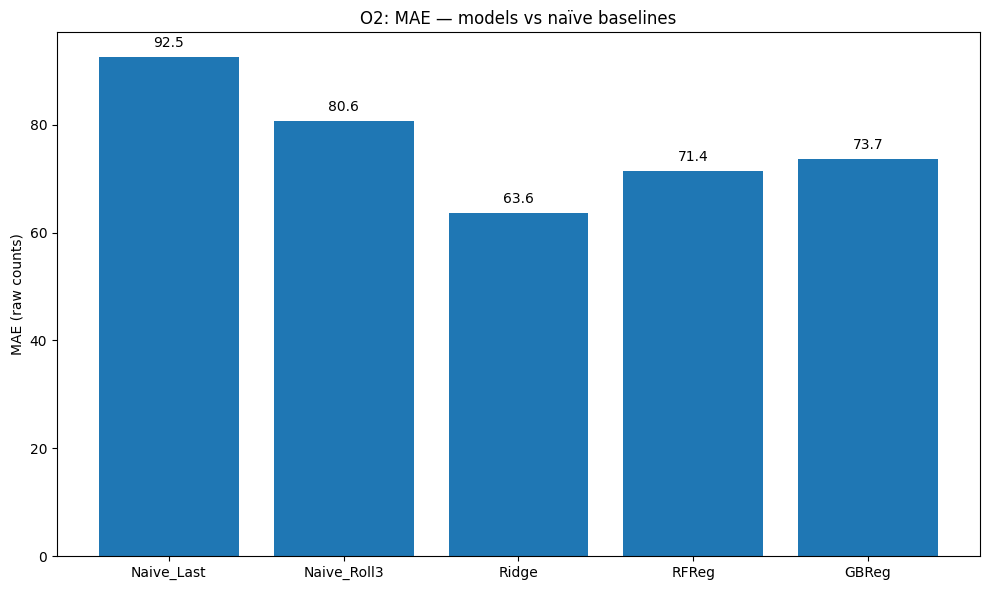

In [8]:

# ==== 7. Objective 2 — Regression vs naïve (MAE, raw count scale) ====
from sklearn.metrics import mean_absolute_error

# Naïve baselines computed on the supervised panel, then filtered to test index
def naive_last_month(group):
    if "Lag1_Total" in group.columns:
        return group["Lag1_Total"]
    return group["Total"].shift(1)

def naive_roll3(group):
    if "Roll3_Total" in group.columns:
        return group["Roll3_Total"]
    return group["Total"].rolling(3, min_periods=1).mean()

naive_last_all = df_sup.groupby("District", group_keys=False).apply(naive_last_month)
naive_roll3_all = df_sup.groupby("District", group_keys=False).apply(naive_roll3)

rfreg = RandomForestRegressor(n_estimators=500, max_depth=None, min_samples_leaf=2, random_state=SEED, n_jobs=-1)
gbreg = GradientBoostingRegressor(n_estimators=800, learning_rate=0.03, max_depth=3, subsample=0.8, random_state=SEED)
ridge = Ridge(alpha=1.0, random_state=SEED)

rfreg.fit(X_train, y_train_reg)
gbreg.fit(X_train, y_train_reg)
ridge.fit(X_train, y_train_reg)

preds = {
    "Naive_Last": naive_last_all.loc[X_test.index],
    "Naive_Roll3": naive_roll3_all.loc[X_test.index],
    "Ridge": pd.Series(ridge.predict(X_test), index=X_test.index),
    "RFReg": pd.Series(rfreg.predict(X_test), index=X_test.index),
    "GBReg": pd.Series(gbreg.predict(X_test), index=X_test.index),
}

# Fill minor gaps in naïve predictions for fair MAE
mae_scores = {k: mean_absolute_error(y_test_reg, v.fillna(method="ffill").fillna(method="bfill")) for k,v in preds.items()}
print("MAE:", {k: round(v, 2) for k,v in mae_scores.items()})

plt.figure(figsize=(10,6))
labels = list(mae_scores.keys()); vals = [mae_scores[k] for k in labels]
plt.bar(labels, vals)
for i, v in enumerate(vals):
    plt.text(i, v + max(0.02*max(vals), 1.0), f"{v:.1f}", ha="center")
plt.ylabel("MAE (raw counts)")
plt.title("O2: MAE — models vs naïve baselines")
out57 = os.path.join(FIG_DIR, "fig57_mae_models_vs_naive.png")
plt.tight_layout(); plt.savefig(out57, dpi=150, bbox_inches="tight"); print("Saved:", out57)
plt.show()
